# IDS Model Code By Python.

##### Importing the required libraries.

In [2]:
#Activate greedy completion PENDING DEPRECTION.This is now mostly taken care of with Jedi.
#This will enable completion on elements of lists, results of function calls,etc.
%config IPCompleter.greedy=True

#pandas is a popular Python-based data analysis toolkit which can be imported using 
#import pandas as pd. 
import pandas as pd

#Seaborn is a Python data visualization library built on top of Matplotlib. 
import seaborn as sns

#the np can be used to call the numpy library and related functions and data types.
#NumPy contains a multi-dimensional array and matrix data structures.
import numpy as np

#Matplotlib is a plotting library 
import matplotlib as matplot

#pyplot is a collection of command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

##### Reading in the data (training & testing),

We will use Pandas to read in the data, The head() function is used to get the first n rows, here will get first 5 rows.
then combine training & testing datasets to make the woek more easier.
Eliminating the "id" column because it does not affect the work.

In [3]:
train = pd.read_csv('data/UNSW_NB15_training-set.csv')
test = pd.read_csv('data/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

##### Fixing the contamination issue in the dataset by making it less than 0.5 according to the properties of the used algorithm.

In [4]:
# Contamination means pollution (outliers) in data.
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.55
test  contamination  0.68 

contamination is 0.55, which is greater than 0.5. Fixing...
contamination is now 0.45


##### Encoding the textual value columns to be as int values.

 The targeted columns are (attack cat, proto, service, state).

In [5]:
#Encode target labels with value between 0 and n_classes-1
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'Normal', 'Worms', 'Fuzzers', 'Analysis', 'Reconnaissance', 'DoS', 'Exploits', 'Backdoor', 'Shellcode', 'Generic'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32 Which is, ['Normal']
mode 0.3609225646458884 %


In [6]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(5)

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,119,0,5,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,6,0
1,0.000008,119,0,5,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,6,0
2,0.000005,119,0,5,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,6,0
3,0.000006,119,0,5,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,6,0
4,0.000010,119,0,5,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,6,0


##### Split the dataset into train and test data

set test_size’ to 0.2 => 20% of data for testing & 80% for training 
Setting ‘stratify’ to y makes our training split represent the proportion of each value in the y variable.

In [7]:
data_x = combined_data.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data.loc[:,['label']]
# del combined_data 
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42, stratify=data_y) 

In [8]:
X_train.shape
y_train.shape
X_test.shape  
y_test.shape

(206138, 42)

(206138, 1)

(51535, 42)

(51535, 1)

##### Building and training the models & Testing the models

Start with DecisionTreeClassifier & RandomForestClassifier Models, then get the testing result.

In [9]:
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
DTC = DecisionTreeClassifier()

list_of_CLFs_names = []
list_of_CLFs = [DTC,RFC]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train.values.ravel())
    pred = clf.score(X_test,y_test)
    name = str(type(clf)).split(".")[-1][:-2]
    print("Acc: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

Acc: 0.93738 for the DecisionTreeClassifier
Acc: 0.95279 for the RandomForestClassifier


KNN Model, create a list "scores" to store the Accuracy for each iteration of the loop where 
the k-neighbor will change from 1 to 25 then will print this list

In [10]:
k_range = range(1, 26)
scores = []
for k in k_range:
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors = k)
    # Fit the classifier to the data
    knn.fit(X_train,y_train.values.ravel())
    y_pred = knn.predict(X_test) 
    scores.append(metrics.accuracy_score(y_test, y_pred ))
    print("Accuracy with " + str(k) + "  neighbors is : " + str(metrics.accuracy_score(y_test, y_pred )))

KNeighborsClassifier(n_neighbors=1)

Accuracy with 1  neighbors is : 0.8459881633841079


KNeighborsClassifier(n_neighbors=2)

Accuracy with 2  neighbors is : 0.8211312700106723


KNeighborsClassifier(n_neighbors=3)

Accuracy with 3  neighbors is : 0.8487823809061803


KNeighborsClassifier(n_neighbors=4)

Accuracy with 4  neighbors is : 0.8331037159212186


KNeighborsClassifier()

Accuracy with 5  neighbors is : 0.8518288541767731


KNeighborsClassifier(n_neighbors=6)

Accuracy with 6  neighbors is : 0.8424371786164743


KNeighborsClassifier(n_neighbors=7)

Accuracy with 7  neighbors is : 0.8541767730668478


KNeighborsClassifier(n_neighbors=8)

Accuracy with 8  neighbors is : 0.8475016978752304


KNeighborsClassifier(n_neighbors=9)

Accuracy with 9  neighbors is : 0.8555350732511885


KNeighborsClassifier(n_neighbors=10)

Accuracy with 10  neighbors is : 0.8495585524400893


KNeighborsClassifier(n_neighbors=11)

Accuracy with 11  neighbors is : 0.8571456291840497


KNeighborsClassifier(n_neighbors=12)

Accuracy with 12  neighbors is : 0.8521587270786843


KNeighborsClassifier(n_neighbors=13)

Accuracy with 13  neighbors is : 0.8592801009022994


KNeighborsClassifier(n_neighbors=14)

Accuracy with 14  neighbors is : 0.8545066459687591


KNeighborsClassifier(n_neighbors=15)

Accuracy with 15  neighbors is : 0.8592995051906471


KNeighborsClassifier(n_neighbors=16)

Accuracy with 16  neighbors is : 0.8563694576501407


KNeighborsClassifier(n_neighbors=17)

Accuracy with 17  neighbors is : 0.8603861453381197


KNeighborsClassifier(n_neighbors=18)

Accuracy with 18  neighbors is : 0.8575725235276996


KNeighborsClassifier(n_neighbors=19)

Accuracy with 19  neighbors is : 0.8617444455224604


KNeighborsClassifier(n_neighbors=20)

Accuracy with 20  neighbors is : 0.8588726108469972


KNeighborsClassifier(n_neighbors=21)

Accuracy with 21  neighbors is : 0.8625206170563695


KNeighborsClassifier(n_neighbors=22)

Accuracy with 22  neighbors is : 0.8599204424177743


KNeighborsClassifier(n_neighbors=23)

Accuracy with 23  neighbors is : 0.8631221499951489


KNeighborsClassifier(n_neighbors=24)

Accuracy with 24  neighbors is : 0.8613175511788105


KNeighborsClassifier(n_neighbors=25)

Accuracy with 25  neighbors is : 0.8631803628601921


Text(0.5, 0, 'Values for k in KNN')

Text(0, 0.5, 'Testing Accuracy')

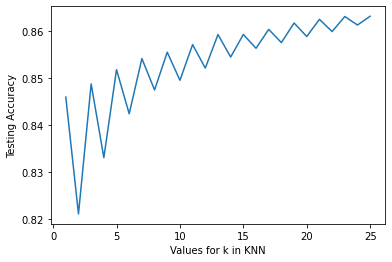

In [11]:
plt.plot(k_range, scores)
plt.xlabel('Values for k in KNN')
plt.ylabel('Testing Accuracy')